# Notes

Using cci30 as a hedge im getting avg beta of 0.08 for some reason, somethings wrong because cci30 and btc are quite correlated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

binance_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/binance/ohlc/perps/combined_enriched.csv"
bybit_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/bybit/ohlc/perps/combined_enriched.csv"
hyperliquid_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/hyperliquid/ohlc/perps/combined_enriched.csv"

df = pd.read_csv(binance_path)
df = df.sort_values(by=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)

In [2]:
# 1) Compute each coin’s true days since listing (using its first-ever timestamp)
first_list = df.groupby('symbol')['timestamp'].transform('min')
df['days_since_list'] = (df['timestamp'] - first_list).dt.days
df['signal'] = np.where(df['days_since_list'] < 100, -1, 0)

# Average beta of new listings

In [3]:
import pandas as pd
import numpy as np

# --- Filter the date range ---------------------------------------------------
df = df[df.timestamp > '2023-01-01']
df = df[df.timestamp < '2025-01-01']

# --- 1. Ensure returns exist ------------------------------------------------
if 'ret' not in df.columns:
    df['ret'] = df.groupby('symbol')['close'].pct_change()

# --- 2. Get hedge symbol returns --------------------------------------------
hedge_symbol = 'BTC'
btc_ret = (
    df[df['symbol'] == hedge_symbol]
    .set_index('timestamp')['ret']
    .rename('btc_ret')
)

# --- 3. Filter listing coins (first 100 days) --------------------------------
listing_df = df[
    (df['symbol'] != hedge_symbol) &
    (df['days_since_list'] <= 100)
][['timestamp', 'symbol', 'ret']]

# --- 4. Pivot to wide, align with hedge_symbol ------------------------------
rets_listing = listing_df.pivot(
    index='timestamp',
    columns='symbol',
    values='ret'
)
data = rets_listing.join(btc_ret, how='inner')  # only timestamps where BTC has a ret

# --- 5. Compute β and volatility per coin -----------------------------------
betas = {}
vols  = {}

for sym in rets_listing.columns:
    # align the listing coin returns with BTC returns, drop any NaNs
    sub = data[[sym, 'btc_ret']].dropna()
    if len(sub) > 1 and sub['btc_ret'].var(ddof=1) > 0:
        # β = Cov(sym, BTC) / Var(BTC)
        cov = sub[sym].cov(sub['btc_ret'])
        var = sub['btc_ret'].var(ddof=1)
        betas[sym] = cov / var
        
        # volatility of the listing coin (annualised, using 365-day convention)
        sigma = sub[sym].std(ddof=1) * np.sqrt(365)
        vols[sym] = sigma

# Convert dicts to Series
betas = pd.Series(betas, name='beta_to_btc')
vols  = pd.Series(vols, name='volatility_annualised')

# --- 6. Print β, vol, and their summary stats --------------------------------
print("Individual coin betas to BTC:")
print(betas)

print("\nIndividual coin annualised volatilities:")
print(vols)

print(f"\nMean beta to BTC for listing coins:   {betas.mean():.4f}")
print(f"Median beta to BTC for listing coins: {betas.median():.4f}")

print(f"\nMean annualised volatility for listing coins:   {vols.mean():.4f}")
print(f"Median annualised volatility for listing coins: {vols.median():.4f}")


Individual coin betas to BTC:
1000000MOG    1.277851
1000BONK      2.165737
1000CAT       1.120771
1000CHEEMS    1.450273
1000FLOKI     1.681896
                ...   
XVS           1.414918
YGG           0.941285
ZETA          0.939962
ZK            1.617662
ZRO           1.506905
Name: beta_to_btc, Length: 232, dtype: float64

Individual coin annualised volatilities:
1000000MOG    1.888491
1000BONK      2.472101
1000CAT       2.114005
1000CHEEMS    1.698661
1000FLOKI     0.861078
                ...   
XVS           0.892422
YGG           1.506223
ZETA          1.470419
ZK            1.146778
ZRO           1.444523
Name: volatility_annualised, Length: 232, dtype: float64

Mean beta to BTC for listing coins:   1.3044
Median beta to BTC for listing coins: 1.2095

Mean annualised volatility for listing coins:   1.4870
Median annualised volatility for listing coins: 1.3358


Text(0.5, 1.0, 'Distribution of Betas to BTC for Listing Coins')

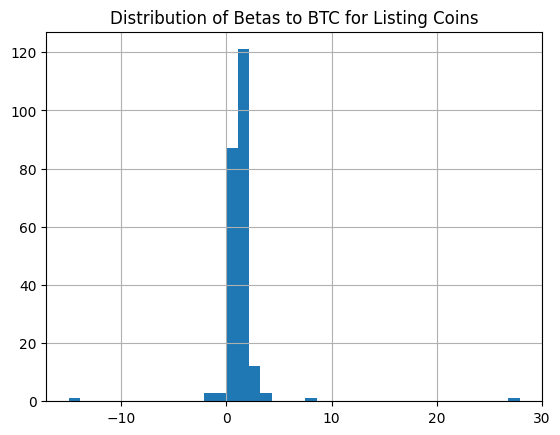

In [4]:
betas.hist(bins=40)
plt.title('Distribution of Betas to BTC for Listing Coins')

# event study

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36495/1944396632.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cum_df = df.groupby('symbol').apply(compute_cum_returns)


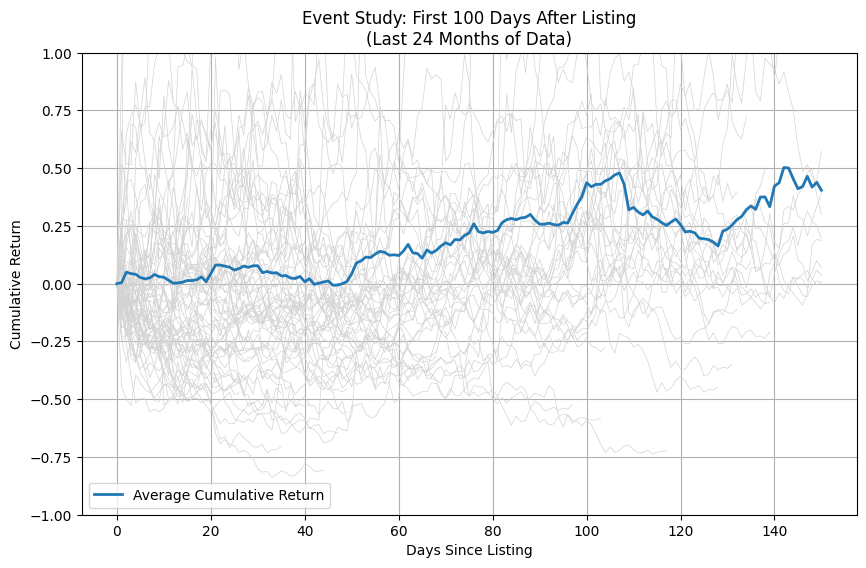

In [5]:
# 2) Filter raw data to only the last 6 months
six_months_ago = pd.Timestamp.now() - pd.DateOffset(months=12)
df = df[df['timestamp'] >= six_months_ago].copy()

# 3) Compute per-symbol cumulative returns over first 100 days since listing
def compute_cum_returns(group):
    group = group.sort_values('timestamp').reset_index(drop=True)
    group['return'] = group['close'].pct_change().fillna(0)
    group['cum_return'] = (1 + group['return']).cumprod() - 1
    # days_since_list already in df, but re-filter to <=100 days
    return group[group['days_since_list'] <= 150][['days_since_list', 'cum_return']]

cum_df = df.groupby('symbol').apply(compute_cum_returns)

# 4) Pivot wide and average across symbols
pivot = cum_df.reset_index().pivot(index='days_since_list', columns='symbol', values='cum_return')
avg_cum = pivot.mean(axis=1)

# 5) Plot
fig, ax = plt.subplots(figsize=(10, 6))
for sym in pivot.columns:
    ax.plot(pivot.index, pivot[sym], color='lightgray', linewidth=0.5)
ax.plot(avg_cum.index, avg_cum.values, linewidth=2, label='Average Cumulative Return')

ax.set_xlabel('Days Since Listing')
ax.set_ylabel('Cumulative Return')
ax.set_title('Event Study: First 100 Days After Listing\n(Last 24 Months of Data)')
ax.set_ylim(-1, 1)
ax.legend()
ax.grid(True)

plt.show()

<Axes: title={'center': 'Avg cum return on new listings[bybit]'}, xlabel='days_since_list'>

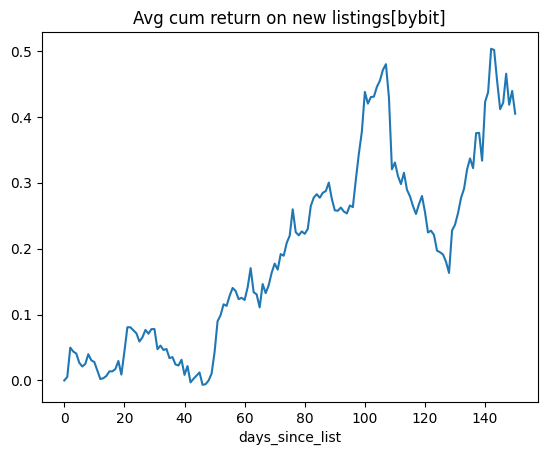

In [6]:
avg_cum.plot(title="Avg cum return on new listings[bybit]")

# Listings count

Total new listings in last 24 months: 369


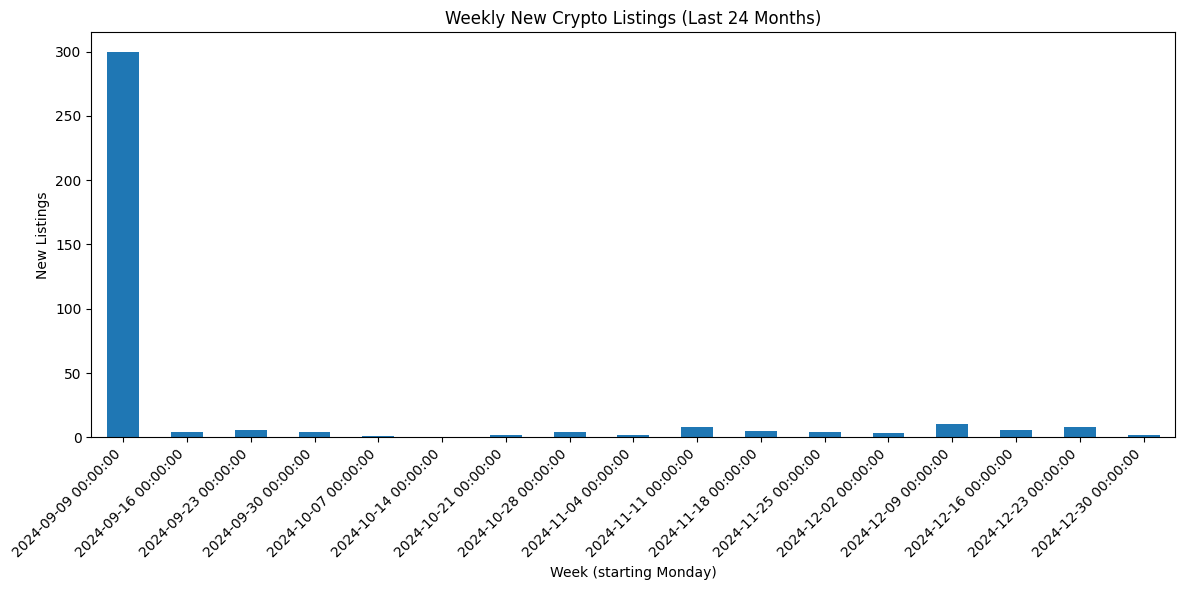

In [7]:
# 2) Compute each token’s true first-ever timestamp
first_list = (
    df
    .groupby('symbol')['timestamp']
    .min()
    .reset_index(name='listing_date')
)

# 3) Now restrict to the last 6 months of listings
six_months_ago = pd.Timestamp.now() - pd.DateOffset(months=23)
recent_listings = first_list[
    first_list['listing_date'] >= six_months_ago
].copy()

# 4) Report how many
print(f"Total new listings in last 24 months: {len(recent_listings)}")

# 5) Aggregate by calendar week (weeks starting Monday) and plot
weekly_counts = (
    recent_listings
    .set_index('listing_date')
    .resample('W-MON')['symbol']
    .count()
)

fig, ax = plt.subplots(figsize=(12, 6))
weekly_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Week (starting Monday)')
ax.set_ylabel('New Listings')
ax.set_title('Weekly New Crypto Listings (Last 24 Months)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Backtest

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36495/641183994.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_daily_equal_short_weights)


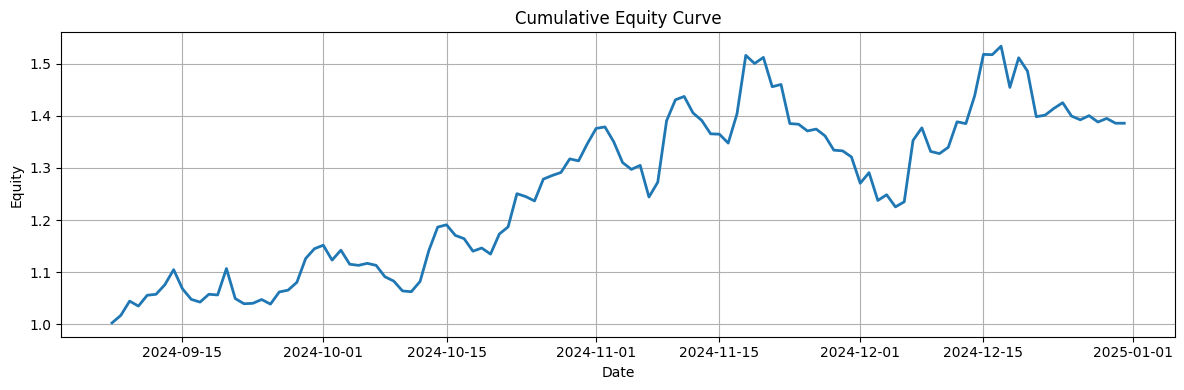

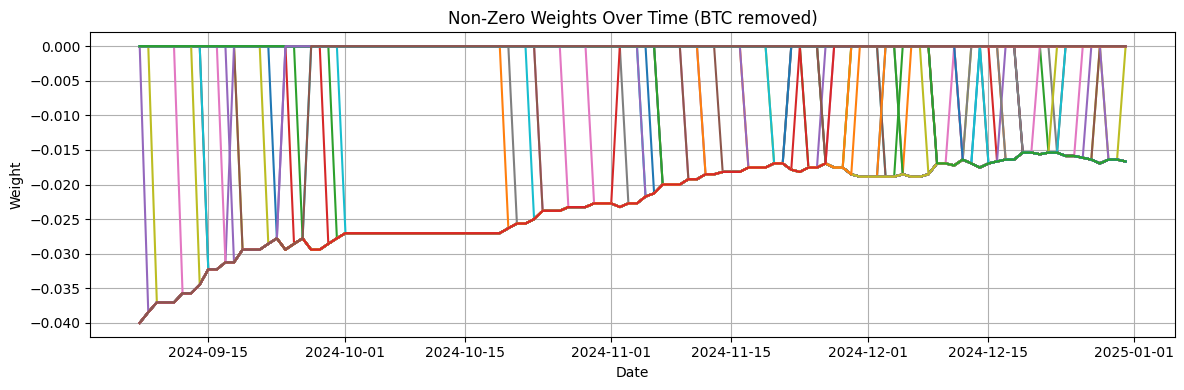

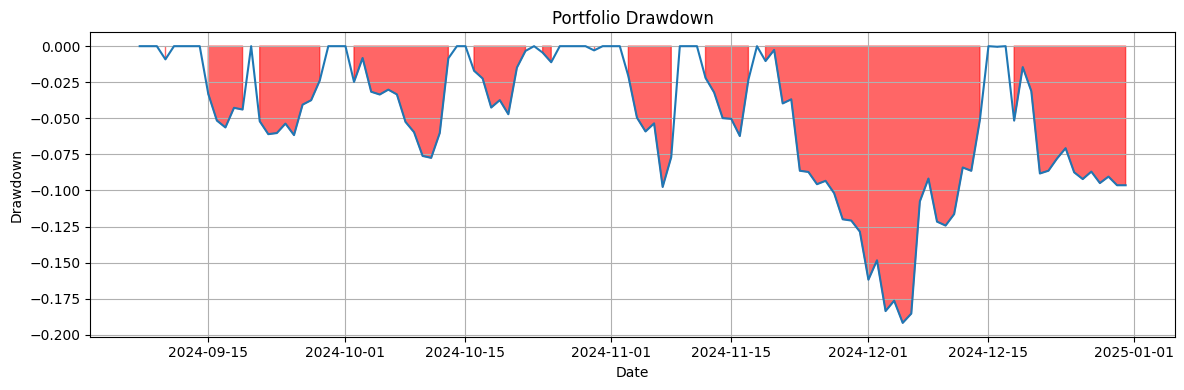

1.83 annualized Sharpe ratio


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Prep -----------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])

df = df[df.timestamp>'2024-06-01']

# --- 2. Compute daily pct returns -------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()
# RET IS NOW THE RETURN from T-1 TO T
# THE WEIGHT IS DECIDED ON DAY T
# SO WE NEED TO LAG THE RETURNS BY ONE DAY TO BE FROM T TO T+1
# WE DO THIS WITH rets_lag = rets_df.shift(-1).fillna(0)

# --- 3. Equal-weight short signals ------------------------------------------
def _daily_equal_short_weights(day):
    shorts = day['signal'] == -1
    n = shorts.sum()
    if n > 0:
        return pd.Series(np.where(shorts, -1/n, 0.0), index=day.index)
    else:
        return pd.Series(0.0, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_daily_equal_short_weights)
)

# --- 4. Pivot weights & lagged returns -------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0)
weights_df['BTC'] = 1.3
rets_df    = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0)

# lag returns by one period to avoid lookahead
rets_lag = rets_df.shift(-1).fillna(0)

# --- 5. Compute portfolio returns & equity ---------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
# port_ret = port_ret*4
equity = (1 + port_ret.cumsum()).rename('cum_equity')

# --- 6. Plot equity curve & non-zero weights in one figure -----------------
import matplotlib.pyplot as plt

# --- Plot 1: Cumulative Equity Curve ---------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Non-Zero Weights Over Time (BTC removed) ----------------------
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Portfolio Drawdown --------------------------------------------
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0, color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{(port_ret.mean()/port_ret.std())*np.sqrt(365):.2f} annualized Sharpe ratio")

# Save the portfolio returns to a CSV file
name = "constant_hedge_equal_weighted_short_listings_100d"
port_ret.rename(name).to_csv(f'../data/backtests/{name}.csv', header=True)


In [9]:
port_ret.std()*np.sqrt(365)

0.6624478851963139

# rolling beta hedge

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36495/1532239368.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_equal_short)


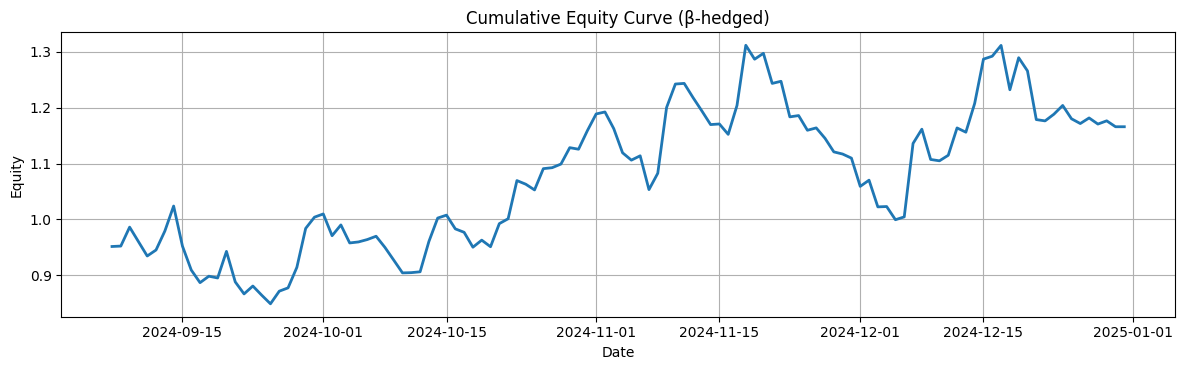

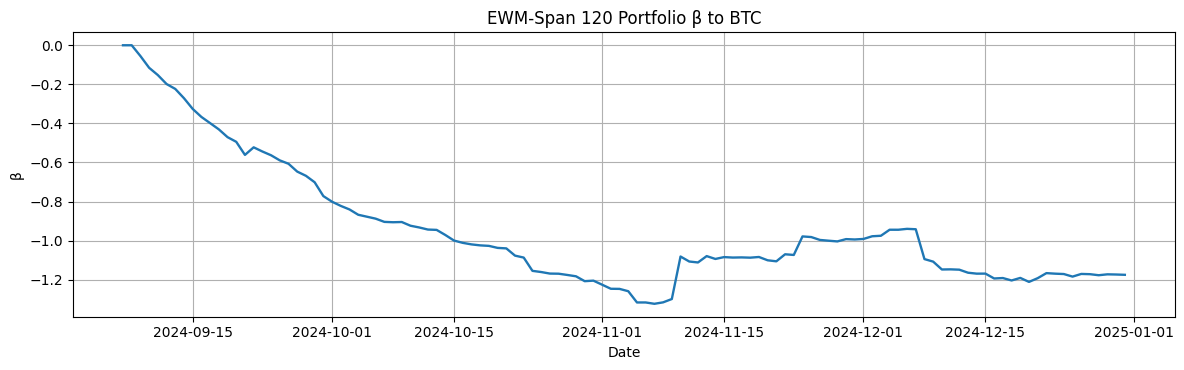

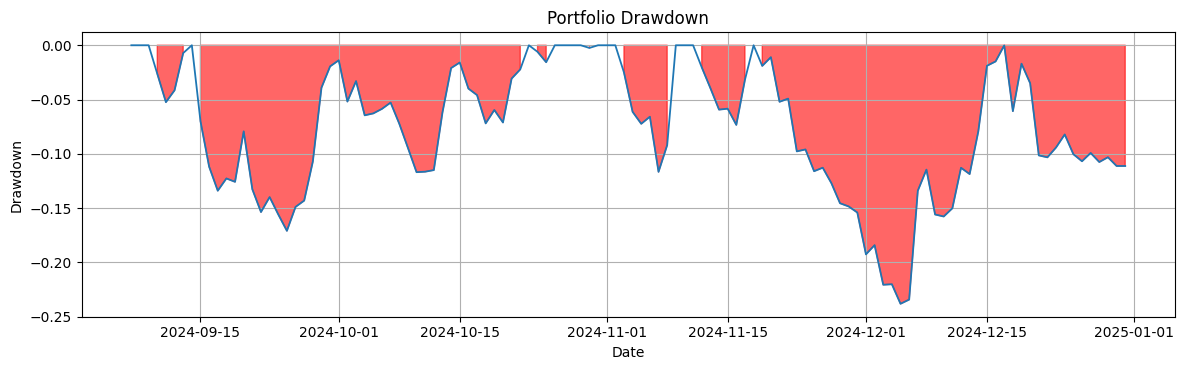

Annualised Sharpe: 0.74


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 1. Prep ----------------------------------------------------
# Choose an EWM span roughly equivalent to a 180-day rolling window (span ≈ window/2)
SPAN = 120

# Convert timestamps and filter period
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = (
    df
    .sort_values(['timestamp', 'symbol'])
    .query("timestamp > '2024-06-01'")
)

# ---------------- 2. Daily returns -------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()

# ---------------- 3. Equal-weight short signals ------------------------------
def _equal_short(day):
    shorts = day['signal'] == -1
    n = shorts.sum()
    if n > 0:
        out = np.where(shorts, -1.0 / n, 0.0)
    else:
        out = np.zeros(len(day))
    return pd.Series(out, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_equal_short)
)

# ---------------- 4. Pivot weights & lagged returns --------------------------
# Pivot to get a wide DataFrame of weights and returns by symbol
weights = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0)
rets    = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0)

# Shift returns by one bar to avoid look‐ahead
rets_lag = rets.shift(-1).fillna(0)

# ---------------- 5. Un-hedged alt-portfolio return --------------------------
# Drop BTC from the alt book (so alts = all non-BTC symbols)
alts     = weights.drop(columns='BTC', errors='ignore')
alts_ret = rets_lag.drop(columns='BTC', errors='ignore')

# Compute the cross‐sectional alt portfolio return at each timestamp
alt_port_ret = (alts * alts_ret).sum(axis=1).rename('alt_port_ret')

# Isolate BTC returns (lagged)
btc_ret = rets_lag['BTC'].rename('btc_ret')

# ---------------- 6. EWM β to BTC  ------------------------------------------
# Compute exponentially‐weighted means for alt and BTC
ewm_alt = alt_port_ret.ewm(span=SPAN, adjust=False).mean()
ewm_btc = btc_ret.ewm(span=SPAN, adjust=False).mean()

# Compute EWM mean of the product for covariance
ewm_ab = (alt_port_ret * btc_ret).ewm(span=SPAN, adjust=False).mean()

# EWM covariance and variance
ewm_cov = ewm_ab - (ewm_alt * ewm_btc)
ewm_var = btc_ret.ewm(span=SPAN, adjust=False).var()

# Raw βₜ = Covₜ / Varₜ, then shift by 1 to avoid look‐ahead (use βₜ₋₁ as today’s hedge)
beta_raw = ewm_cov / ewm_var
beta     = beta_raw.shift(1).fillna(0)

# Attach the BTC‐hedge weight (negative because we’re short alts, long BTC to hedge)
weights['BTC'] = -beta

# ---------------- 7. Hedged portfolio P&L & equity ---------------------------
# Compute total portfolio return (including BTC hedge)
port_ret = (weights * rets_lag).sum(axis=1).rename('port_ret')
equity = (1 + port_ret.cumsum()).rename('cum_equity')

# Restrict performance calculations/plots to 2025+ to match the same period filtering as df
port_ret = port_ret.loc[port_ret.index >= '2024-06-01']
equity   = equity.loc[equity.index >= '2024-06-01']

# ---------------- 8. Plot results --------------------------------------------
# 1) Cumulative Equity Curve
plt.figure(figsize=(12, 3.8))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve (β-hedged)')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Exponentially-Weighted β series
plt.figure(figsize=(12, 3.8))
plt.plot(beta.index, beta, lw=1.7)
plt.title(f'EWM‐Span {SPAN} Portfolio β to BTC')
plt.xlabel('Date')
plt.ylabel('β')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Drawdown
running_max = equity.cummax()
drawdown = equity / running_max - 1

plt.figure(figsize=(12, 3.8))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0, color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.3)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Annualised Sharpe
annualised_sharpe = (port_ret.mean() / port_ret.std()) * np.sqrt(365)
print(f"Annualised Sharpe: {annualised_sharpe:.2f}")

# Save the portfolio returns to a CSV file
name = "rolling_hedge_equal_weighted_short_listings_100d"
port_ret.rename(name).to_csv(f'../data/backtests/{name}.csv', header=True)


# Equal risk backtest naive hedge

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------#
#  0. Parameters
# ---------------------------------------------------------------------------#
VOL_SPAN = 10        # look-back window for vol (trading days)
START   = '2025-01-01'

# ---------------------------------------------------------------------------#
#  1. Prep & returns
# ---------------------------------------------------------------------------#
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = (
    df.sort_values(['timestamp', 'symbol'])
      .loc[lambda x: x['timestamp'] > START]
)

df['ret'] = df.groupby('symbol')['close'].pct_change()

# ---------------------------------------------------------------------------#
#  2. Rolling volatility (annualised)
# ---------------------------------------------------------------------------#
rets_df = (
    df.pivot(index='timestamp', columns='symbol', values='ret')
    #   .fillna(0)
)
vol_df = rets_df.ewm(span=VOL_SPAN, adjust=False).std() * np.sqrt(365)


# shrinkage
LAMBDA = 0.5        # 0 = full pull to 1, 1 = no shrink
# leave NaNs alone so missing vols stay missing
vol_df = vol_df.where(
    vol_df.isna(),                        # condition
    LAMBDA * vol_df + (1 - LAMBDA) * 1.3  # replacement for non-NaN cells
)

# ---------------------------------------------------------------------------#
#  3. Vol-weighted short signals
# ---------------------------------------------------------------------------#
def _equal_risk_short_weights(day):
    shorts = day['signal'] == -1
    symbols = day.loc[shorts, 'symbol'].to_numpy()
    if symbols.size == 0:
        return pd.Series(0.0, index=day.index)          # nothing to short
    
    # look up today’s σ for each shorted symbol
    sigmas = vol_df.loc[day.name, symbols].to_numpy()
    mask   = np.isfinite(sigmas) & (sigmas > 0)
    
    if not mask.any():                                  # no valid vols
        return pd.Series(0.0, index=day.index)
    
    inv_sigma = 1 / sigmas[mask]
    raw = -inv_sigma / inv_sigma.sum()                  # neg sign ⇒ short
    
    out = np.zeros(len(day))
    out[np.flatnonzero(shorts)[mask]] = raw
    return pd.Series(out, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_equal_risk_short_weights)
)

# ---------------------------------------------------------------------------#
#  4. Assemble final weight & return matrices
# ---------------------------------------------------------------------------#
weights_df = (
    df.pivot(index='timestamp', columns='symbol', values='weight')
      .fillna(0)
)

# --- BTC hedge: constant +1.3 (leave as-is) -------------------------------
weights_df['BTC'] = 1.3
# If you want BTC *also* in the equal-risk pool, comment the
# line above and just keep whatever weight came from step 3.

# lagged returns (no look-ahead)
rets_lag = rets_df.shift(-1).fillna(0)

# ---------------------------------------------------------------------------#
#  5. Portfolio P&L
# ---------------------------------------------------------------------------#
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity = (1 + port_ret.cumsum()).rename('cum_equity')

# ---------------------------------------------------------------------------#
#  6. Plots
# ---------------------------------------------------------------------------#
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve (Equal-Risk Shorts)')
plt.xlabel('Date'); plt.ylabel('Equity'); plt.grid(True); plt.tight_layout(); plt.show()

nz = (
    weights_df.drop(columns='BTC', errors='ignore')
              .loc[:, lambda x: (x != 0).any(axis=0)]
)
plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date'); plt.ylabel('Weight'); plt.grid(True); plt.tight_layout(); plt.show()

running_max = equity.cummax()
drawdown = equity / running_max - 1
plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown<0, color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown'); plt.xlabel('Date'); plt.ylabel('Drawdown')
plt.grid(True); plt.tight_layout(); plt.show()

active_counts = (weights_df.drop(columns='BTC', errors='ignore') != 0).sum(axis=1)
plt.figure(figsize=(12, 4))
plt.plot(active_counts.index, active_counts, lw=2)
plt.title('Number of Symbols in Portfolio Over Time')
plt.xlabel('Date'); plt.ylabel('Active Symbol Count'); plt.grid(True); plt.tight_layout(); plt.show()

print(f"Annualised Sharpe: {(port_ret.mean()/port_ret.std())*np.sqrt(365):.2f}")

# Save the portfolio returns to a CSV file
name = "equal_risk_short_listings"
port_ret.rename(name).to_csv(f'../data/backtests/{name}.csv', header=True)


/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36495/3086290410.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_equal_risk_short_weights)


ValueError: Columns must be same length as key

# Equal risk backtest shrunken EWM VOL, constant hedge

I dont know why this doesnt work

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------#
#  0. Parameters
# ---------------------------------------------------------------------------#
START         = '2024-06-01'
VOL_SPAN       = 10
SHRINK_ALPHA   = 0.2          # or whatever you like
PRIOR_VOL      = 1.3           # the constant you’re shrinking toward
VOL_FLOOR      = 0.0          # 5 % p.a. floor on σ
MIN_OBS        = 0            # don’t use a name until it has ≥10 returns


# ---------------------------------------------------------------------------#
#  1. Prep & returns
# ---------------------------------------------------------------------------#
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = (
    df.sort_values(['timestamp', 'symbol'])
      .loc[lambda x: x['timestamp'] > START]
)

df['ret'] = df.groupby('symbol')['close'].pct_change()

# ---------------------------------------------------------------------------#
#  2. Rolling volatility (annualised)  ←---- NOW WITH SHRINKAGE
# ---------------------------------------------------------------------------#
rets_df = (
    df.pivot(index='timestamp', columns='symbol', values='ret')
      .fillna(0)
)

# 1. EWMA σ
vol_raw  = rets_df.ewm(span=VOL_SPAN, adjust=False).std() * np.sqrt(365)

# 2. Require a minimum history
enough_history = rets_df.rolling(VOL_SPAN).count().fillna(0) >= MIN_OBS
vol_raw = vol_raw.where(enough_history)

# 3. Shrink toward the prior, then apply a floor
vol_df = (1 - SHRINK_ALPHA) * vol_raw + SHRINK_ALPHA * PRIOR_VOL
vol_df = vol_df.clip(lower=VOL_FLOOR)

# ---------------------------------------------------------------------------#
# 5.  Fill NaNs in returns *after* all volatility work
# ---------------------------------------------------------------------------#
rets_df = rets_df.fillna(0)                          # safe to do now
rets_lag = rets_df.shift(-1).fillna(0)

# ---------------------------------------------------------------------------#
#  3. Vol-weighted short signals
# ---------------------------------------------------------------------------#
def _equal_risk_short_weights(day):
    shorts  = day['signal'] == -1
    symbols = day.loc[shorts, 'symbol'].to_numpy()
    if symbols.size == 0:
        return pd.Series(0.0, index=day.index)

    # look up today’s (shrunk) σ for the to-be-shorted symbols
    sigmas = vol_df.loc[day.name, symbols].to_numpy()
    mask   = np.isfinite(sigmas) & (sigmas > 0)

    if not mask.any():
        return pd.Series(0.0, index=day.index)

    inv_sigma = 1 / sigmas[mask]
    raw       = -inv_sigma / inv_sigma.sum()            # neg sign ⇒ short

    out = np.zeros(len(day))
    out[np.flatnonzero(shorts)[mask]] = raw
    return pd.Series(out, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_equal_risk_short_weights)
)

# ---------------------------------------------------------------------------#
#  4. Assemble final weight & return matrices
# ---------------------------------------------------------------------------#
weights_df = (
    df.pivot(index='timestamp', columns='symbol', values='weight')
      .fillna(0)
)

# --- BTC hedge: constant +1.3 ----------------------------------------------
weights_df['BTC'] = 1.3

# lagged returns (no look-ahead bias)
rets_lag = rets_df.shift(-1).fillna(0)

# ---------------------------------------------------------------------------#
#  5. Portfolio P&L
# ---------------------------------------------------------------------------#
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity = (1 + port_ret.cumsum()).rename('cum_equity')

# ---------------------------------------------------------------------------#
#  6. Plots
# ---------------------------------------------------------------------------#
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve (Equal-Risk Shorts, Shrunk σ)')
plt.xlabel('Date'); plt.ylabel('Equity'); plt.grid(True); plt.tight_layout(); plt.show()

nz = (
    weights_df.drop(columns='BTC', errors='ignore')
              .loc[:, lambda x: (x != 0).any(axis=0)]
)
plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date'); plt.ylabel('Weight'); plt.grid(True); plt.tight_layout(); plt.show()

running_max = equity.cummax()
drawdown    = equity / running_max - 1
plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0, alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown'); plt.xlabel('Date'); plt.ylabel('Drawdown')
plt.grid(True); plt.tight_layout(); plt.show()

print(f"Annualised Sharpe: {(port_ret.mean() / port_ret.std()) * np.sqrt(365):.2f}")


/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_36495/353490217.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_equal_risk_short_weights)


ValueError: Columns must be same length as key

In [ ]:
weights_df.iloc[-1][weights_df.iloc[-1] != 0].sort_values(ascending=False).index#.head(10).plot(kind='barh', figsize=(12, 6))

Index(['BTC', 'SOON', 'SOPH', 'MERL', 'HUMA', 'B', 'NXPC', 'AGT', 'A', 'AWE',
       'HYPE'],
      dtype='object', name='symbol')

# Analytics

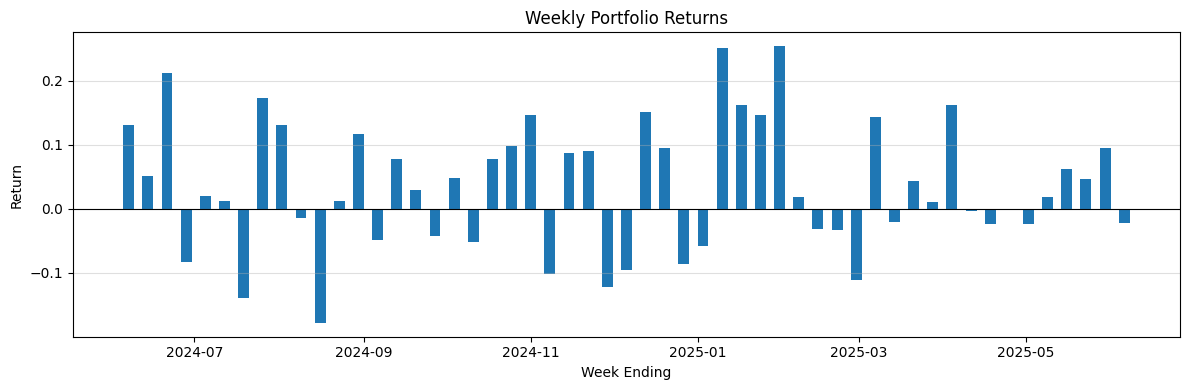

0.03552077062374432

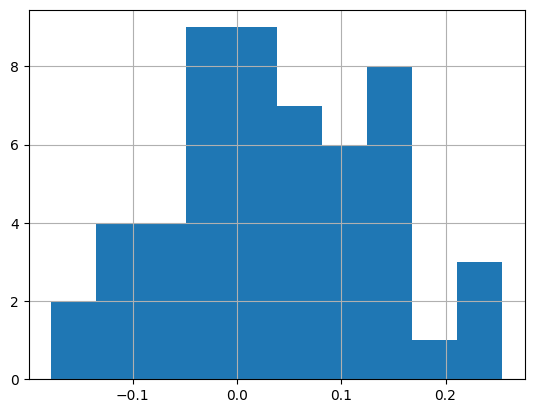

In [ ]:
import matplotlib.pyplot as plt

# ── 1. Convert daily P&L stream to weekly returns ───────────────────────────
# NB: 'W-FRI' ends each week on Friday; change to 'W-SUN' or 'W-MON'
#     if your trading calendar is different.
weekly_ret = port_ret.resample('W-FRI').apply(lambda x: (1 + x).prod() - 1)

# ── 2. Plot ─────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 4))
plt.bar(weekly_ret.index, weekly_ret.values, width=4, align='center')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Weekly Portfolio Returns')
plt.xlabel('Week Ending')
plt.ylabel('Return')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

weekly_ret.hist()
weekly_ret.mean()

In [ ]:
weekly_ret

timestamp
2025-01-03    0.000000
2025-01-10    0.151389
2025-01-17    0.242337
2025-01-24    0.328262
2025-01-31    0.094288
2025-02-07    0.262795
2025-02-14    0.094603
2025-02-21    0.087983
2025-02-28   -0.225501
2025-03-07    0.416866
2025-03-14    0.196123
2025-03-21    0.042568
2025-03-28    0.129078
2025-04-04    0.119781
2025-04-11   -0.022794
2025-04-18    0.063898
2025-04-25    0.117633
2025-05-02   -0.002772
2025-05-09    0.080551
2025-05-16    0.043513
2025-05-23    0.150030
2025-05-30   -0.038383
2025-06-06    0.029631
Freq: W-FRI, Name: price_ret, dtype: float64

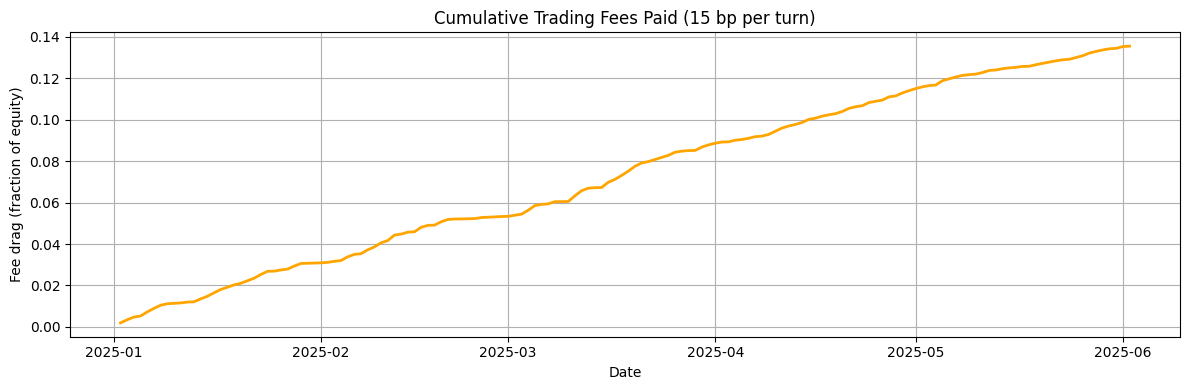

In [ ]:
# ---------------------------------------------------------------------------#
#  5-ter. 15 bp execution fees
# ---------------------------------------------------------------------------#
COST_PCT = 0.0015          # 15 basis-points per notional traded

# Turn-over = |w_t – w_{t-1}|
turnover = weights_df.diff().abs()

# first bar: assume we enter from 0-weight
turnover.iloc[0] = weights_df.iloc[0].abs()

# Fee paid each day (as a fraction of equity):
fee_day = turnover.sum(axis=1) * COST_PCT          # Series

cum_fees = fee_day.cumsum().rename('cum_fees')     # running total

# ---------------------------------------------------------------------------#
#  6-bis. Cumulative fees plot
# ---------------------------------------------------------------------------#
plt.figure(figsize=(12, 4))
plt.plot(cum_fees.index, cum_fees, lw=2, color='orange')
plt.title('Cumulative Trading Fees Paid (15 bp per turn)')
plt.xlabel('Date'); plt.ylabel('Fee drag (fraction of equity)')
plt.grid(True); plt.tight_layout(); plt.show()
